In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
data = pd.read_csv("Video_Games_Sales.csv", encoding='cp1252')
data.head(-5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,15 Days,PC,2009.0,Adventure,DTP Entertainment,0.00,0.01,0.00,0.00,0.01,63.0,6.0,5.8,8.0,DTP Entertainment,NaN
16710,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,NaN,NaN,tbd,NaN,Atari,T
16711,Aiyoku no Eustia,PSV,2014.0,Misc,dramatic create,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16712,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Провести EDA и предобработку данных

Для начала проведем предварительный разведочный анализ набора данных, в ходе которого рассмотрим ключевые характеристеки набора:

In [4]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

In [5]:
data.shape

(16719, 16)

In [6]:
data.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

По предыдущему выводу можно увидеть, что столбец "User_Score" расценивается датасетом как объект. Переведём его во float. 

In [7]:
data['User_Score'] = data['User_Score'].str.replace('tbd', '0').astype(float)

data.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object

In [8]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Т.к. пустые значения в отзывах критиков и клиентов показывает то, что этих данных в датасете нет, можно принять эти значения за 0 (не написано ни одного отзыва)

In [9]:
data['User_Score'] = data['User_Score'].fillna('0').astype(float)
data['User_Count'] = data['User_Count'].fillna('0').astype(float)
data['Critic_Score'] = data['Critic_Score'].fillna('0').astype(float)
data['Critic_Count'] = data['Critic_Count'].fillna('0').astype(float)

Далее удалим все строки, в которых не определено значение рейтинга. Т.к. рейтинг является важной частью оценки, не будем рассматривать игры, в которых он отсутствует

In [10]:
data = data.dropna(subset="Rating")
print(data.shape)
print(data.isna().sum())

(9950, 16)
Name                 0
Platform             0
Year_of_Release    181
Genre                0
Publisher            7
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score         0
Critic_Count         0
User_Score           0
User_Count           0
Developer            0
Rating               0
dtype: int64


Теперь можно увидеть, что осталось немного пустых значений в столбцах "Year_of_Release" и "Publisher", предположим, что их можно удалить без потери важной информации

In [11]:
data.loc[data.isnull().any(axis=1)]
data = data.dropna(subset="Year_of_Release")
data = data.dropna(subset="Publisher")

In [12]:
data.isna().sum()

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64

Теперь, когда мы полностью избавились от пустых значений, перейдём к анализу столбцов. Так как значение "Global_Sales" учитывает продажи игры по всем регионам, можно удалить продажи в конкретных странах и оставить только глобальные продажи

In [13]:
df = data.copy()
df.drop('NA_Sales', inplace=True, axis=1)
df.drop('EU_Sales', inplace=True, axis=1)
df.drop('JP_Sales', inplace=True, axis=1)
df.drop('Other_Sales', inplace=True, axis=1)
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,E


Так же предположим, что название игры никак не влияет на её продажи, поэтому удалим этот столбец

In [14]:
df.drop('Name', inplace=True, axis=1)
df.head(-5)

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...
16685,PC,1997.0,Strategy,Microprose,0.01,0.0,0.0,8.1,12.0,Team 17,K-A
16692,3DS,2011.0,Sports,Mastiff,0.01,0.0,0.0,0.0,0.0,Mastiff,T
16696,PC,2014.0,Action,Konami Digital Entertainment,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16699,GBA,2001.0,Action,Titus,0.01,67.0,9.0,0.0,0.0,Planet Interactive,E


In [15]:
df.loc[df.duplicated()]

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
8691,DS,2008.0,Sports,Ubisoft,0.16,0.0,0.0,0.0,0.0,Lexis Numerique,E
11679,Wii,2009.0,Misc,Konami Digital Entertainment,0.08,0.0,0.0,0.0,0.0,Konami,E
11913,DS,2009.0,Simulation,505 Games,0.07,0.0,0.0,0.0,0.0,505 Games,E
13456,PC,2010.0,Misc,Warner Bros. Interactive Entertainment,0.05,0.0,0.0,0.0,0.0,Black Lantern Studios,EC
14075,DS,2010.0,Puzzle,Foreign Media Games,0.04,0.0,0.0,0.0,0.0,Foreign Media,E
15403,XOne,2016.0,Misc,Atari,0.02,0.0,0.0,0.0,0.0,"Atari, Atari SA",E
15915,DS,2007.0,Misc,Konami Digital Entertainment,0.02,0.0,0.0,0.0,0.0,Vanpool,E
16525,XB,2002.0,Sports,Konami Digital Entertainment,0.01,0.0,0.0,0.0,0.0,Konami,E
16692,3DS,2011.0,Sports,Mastiff,0.01,0.0,0.0,0.0,0.0,Mastiff,T


В итоге можно предположить, что лучше всего в данном случае подойдёт задача регрессии, так как именно она сможет помочь определить числовое значение

## Numerical columns

In [16]:
num_cols = df.select_dtypes(exclude='object')
num_cols.shape

(9767, 6)

In [17]:
num_cols.describe()

,Year_of_Release,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000
mean,2007.582369,0.613770,55.815911,21.448654,5.384673,123.523907
std,4.101736,1.674662,29.881202,20.054309,3.329960,497.515447
min,1985.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,0.080000,47.000000,6.000000,2.000000,4.000000
50%,2008.000000,0.210000,66.000000,17.000000,6.900000,14.000000
75%,2010.000000,0.570000,77.000000,32.000000,8.000000,51.000000
max,2020.000000,82.530000,98.000000,113.000000,9.700000,10665.000000


## Categorical columns

In [18]:
cat_cols = df.select_dtypes(include="object")
cat_cols.describe()

,Platform,Genre,Publisher,Developer,Rating
count,9767,9767,9767,9767,9767
unique,17,12,332,1655,8
top,PS2,Action,Electronic Arts,Ubisoft,E
freq,1456,2146,1127,201,3921


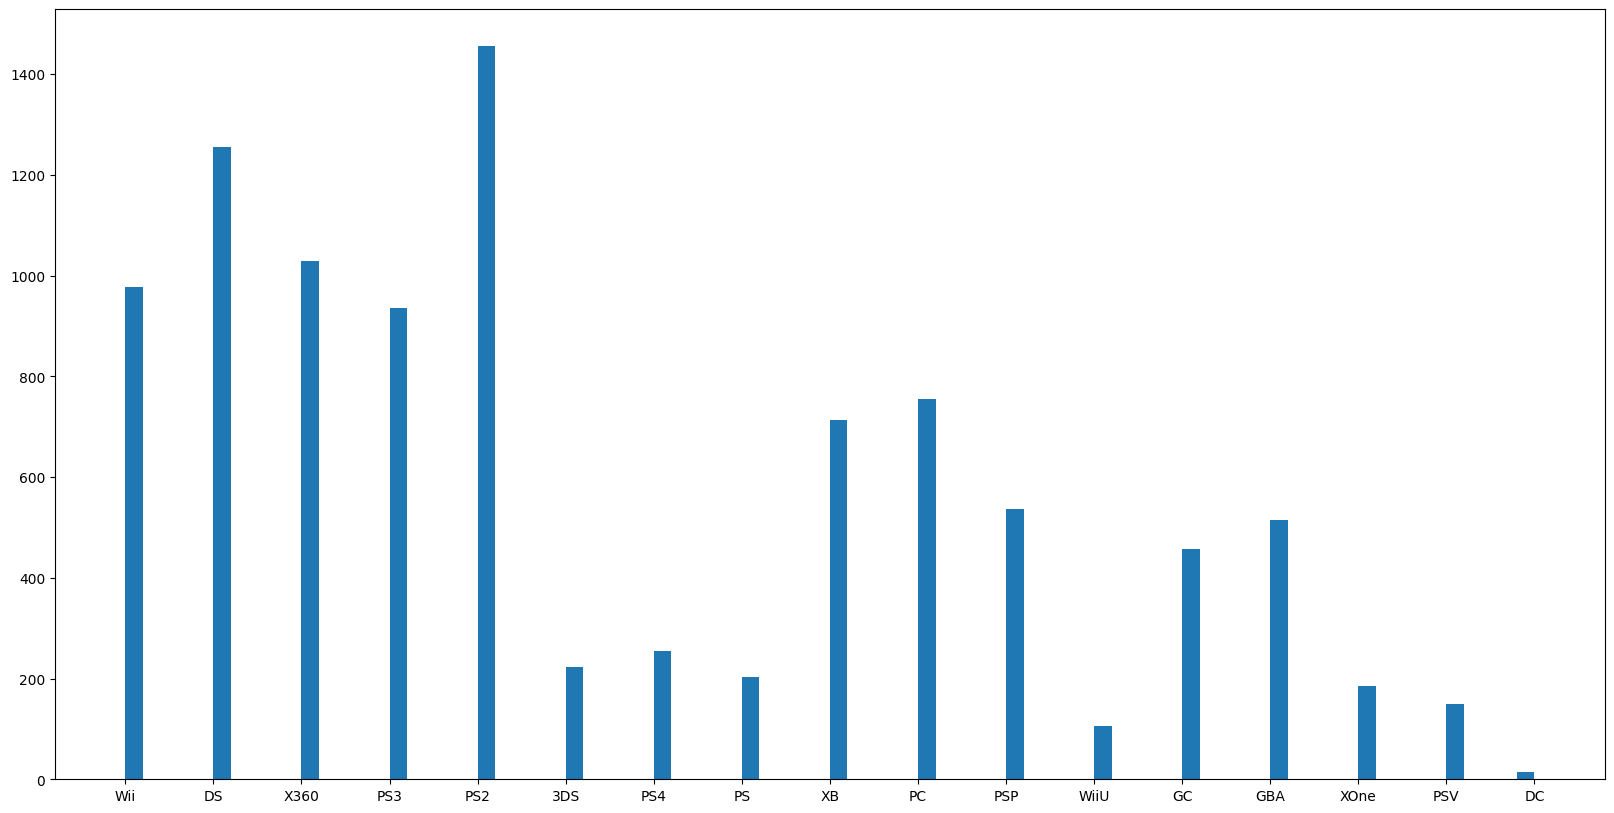

In [19]:
plt.figure(figsize=(20, 10))
plt.hist(df['Platform'], bins=80)
plt.show()

### Try label encoding

Так как рейтинг влияет на итоговое количество продаж, закодируем его

In [20]:
le = LabelEncoder()
df['Rating'] = le.fit_transform(cat_cols['Rating'])
df.head()

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8.0,322.0,Nintendo,1
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,1
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,1
6,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,Nintendo,1
7,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,1


### Try get dummies

In [21]:
columns_to_encode = ['Platform', 'Genre', 'Publisher', 'Developer']
for c in columns_to_encode:
    dummies = pd.get_dummies(df[c], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(c, axis=1, inplace=True)
df = df.replace({True: 1, False: 0})
df.head(-5)

,Year_of_Release,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,DC,DS,GBA,...,id Software,"id Software, Nerve Software","id Software, Raven Software",n-Space,neo Software,odenis studio,oeFun,puzzle.tv,syn Sophia,zSlide
0,2006.0,82.53,76.0,51.0,8.0,322.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008.0,35.52,82.0,73.0,8.3,709.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,32.77,80.0,73.0,8.0,192.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006.0,29.80,89.0,65.0,8.5,431.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,2006.0,28.92,58.0,41.0,6.6,129.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16685,1997.0,0.01,0.0,0.0,8.1,12.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16692,2011.0,0.01,0.0,0.0,0.0,0.0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16696,2014.0,0.01,80.0,20.0,7.6,412.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16699,2001.0,0.01,67.0,9.0,0.0,0.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Scatterplots with targets

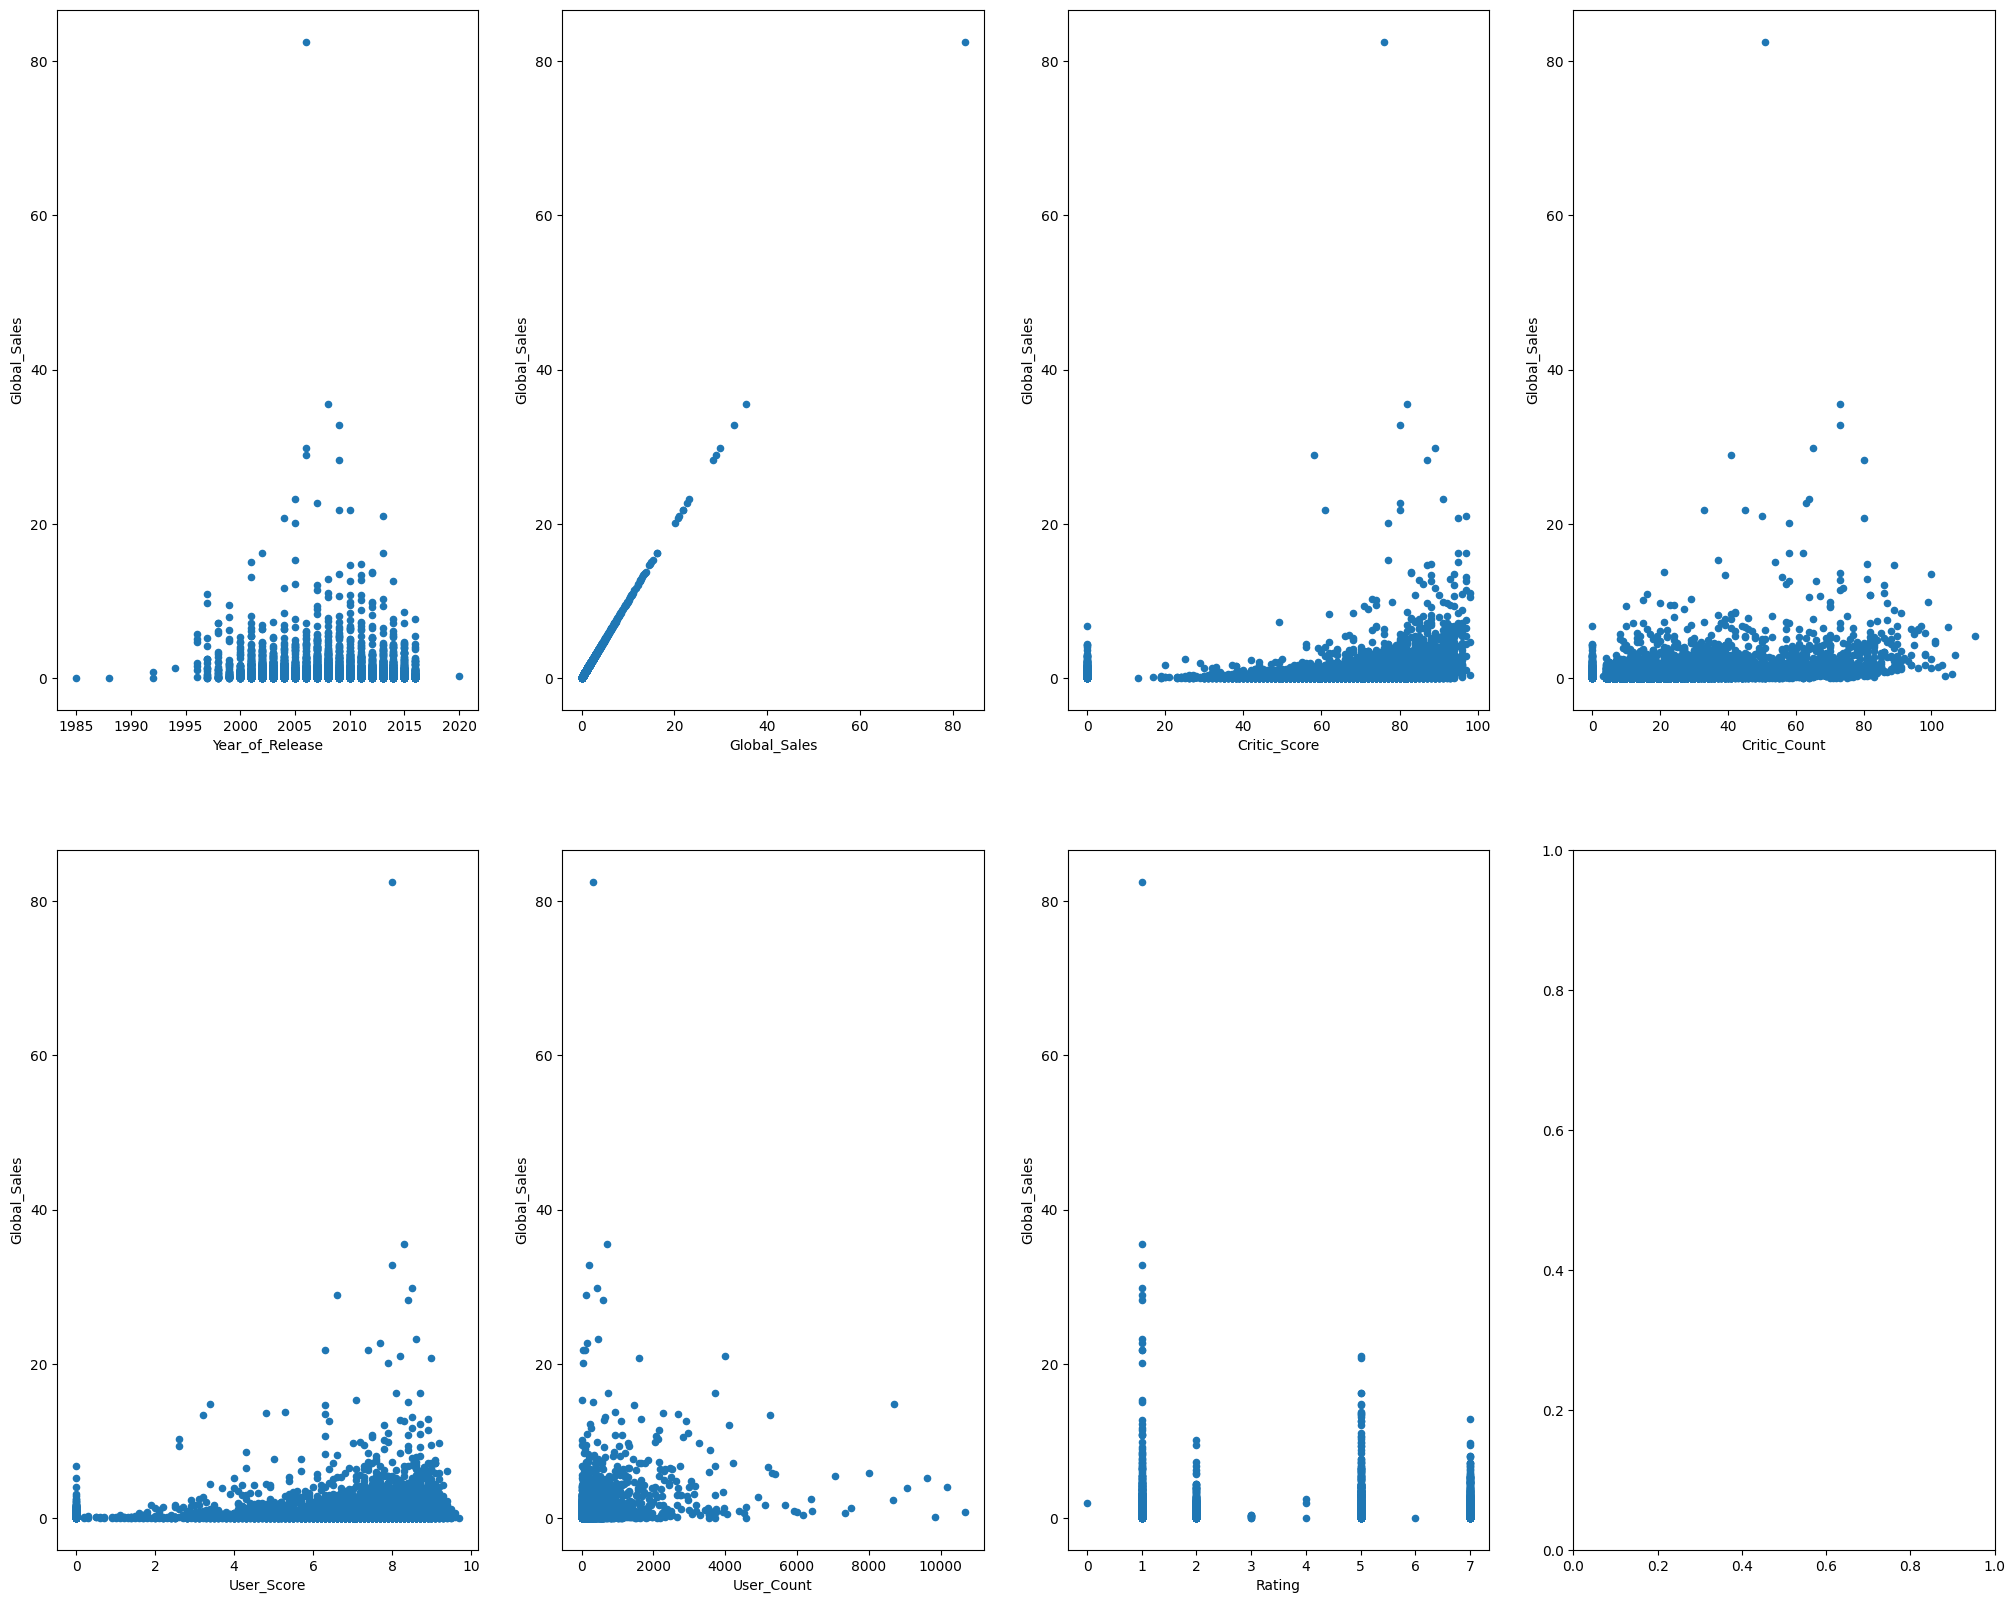

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 20))
for idx, feature in enumerate(df.columns[:7]):
    df.plot(feature, "Global_Sales", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

## Outliers

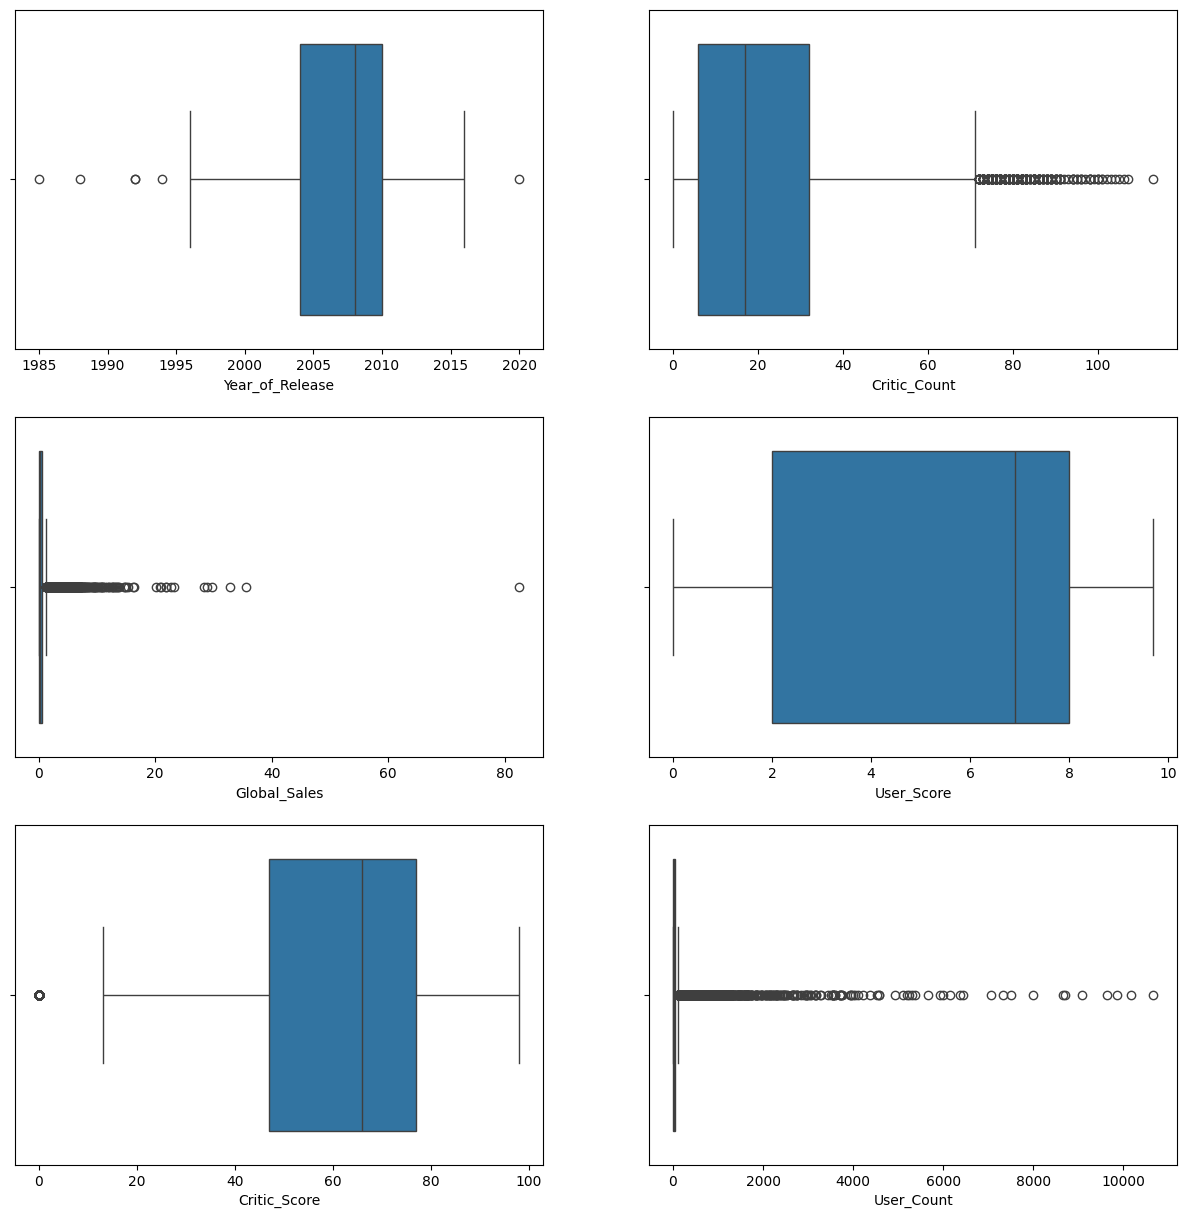

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
count = 0
for idx, feature in enumerate(num_cols.columns[0:]):
    sns.boxplot(x=df[feature], ax=axes[count % 3, count // 3])
    count += 1

In [24]:
for col in num_cols.columns[0:]:
    print(f'Outliers for {col} column: {boxplot_stats(df[col]).pop(0)["fliers"]}\n')

Outliers for Year_of_Release column: [1994. 1992. 1985. 1992. 1988. 2020.]

Outliers for Global_Sales column: [82.53 35.52 32.77 ...  1.31  1.31  1.31]

Outliers for Critic_Score column: [0. 0. 0. ... 0. 0. 0.]

Outliers for Critic_Count column: [ 73.  73.  80.  80.  81.  89.  73. 100.  81.  73.  86.  74.  73.  86.
  82.  82.  99.  87.  89.  91.  75.  87.  84.  73.  82.  90.  97. 105.
  73.  77.  94.  96.  96.  88.  82.  98.  85.  95.  77.  90. 113.  83.
  82.  72.  86.  88.  76.  84.  82. 101.  87.  78.  80.  74.  83. 101.
  82.  75.  88.  90.  83.  95.  77.  81.  80.  83.  76.  79.  89.  81.
  80.  91.  81.  78.  75.  83.  86.  86.  86.  75.  74.  81.  85.  79.
  78.  81.  98.  74.  74. 107.  75.  94.  78.  73.  85.  77.  98.  74.
  88.  90.  81.  85.  74.  83.  88.  87.  92. 100.  79.  73.  75.  81.
  82.  91.  89.  76.  73.  93.  72.  74.  72.  82.  85.  72.  83.  81.
  75.  78.  90.  81.  85.  75.  94.  83.  94.  82. 103.  76.  98.  80.
  77.  74.  75.  81.  73.  79.  78.  80.  77

## Distibutions of num features

<Axes: xlabel='User_Count', ylabel='Density'>

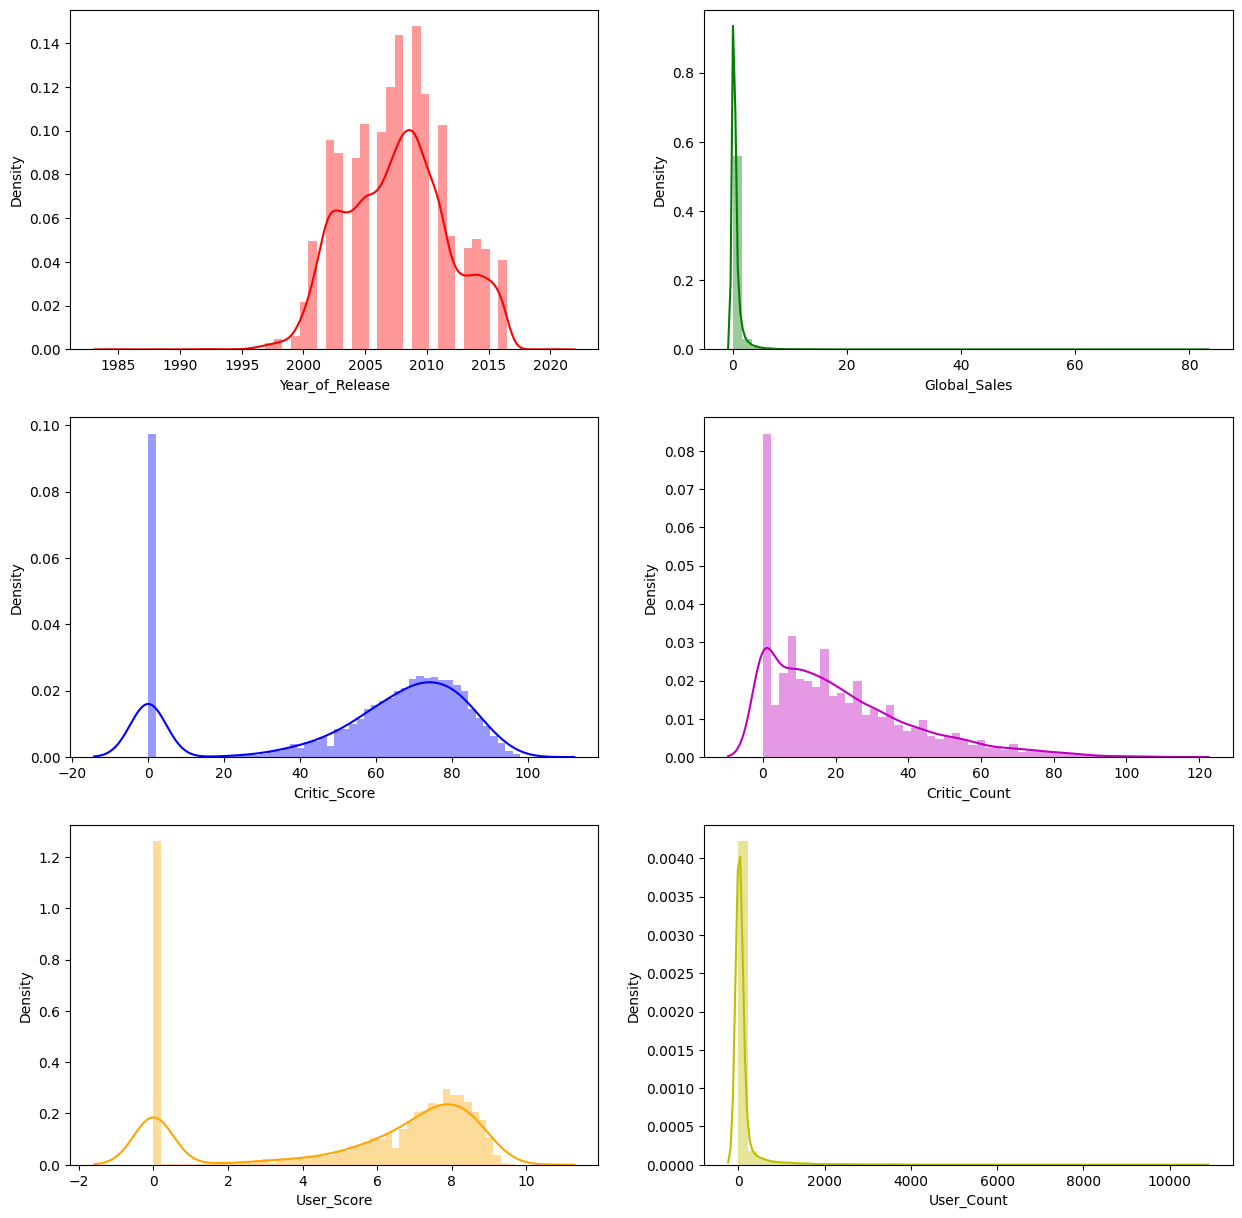

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
sns.distplot(df['Year_of_Release'], bins=50, color='r', ax=axes[0, 0])
sns.distplot(df['Global_Sales'], bins=50, color='g', ax=axes[0, 1])
sns.distplot(df['Critic_Score'], bins=50, color='b', ax=axes[1, 0])
sns.distplot(df['Critic_Count'], bins=50, color='m', ax=axes[1, 1])
sns.distplot(df['User_Score'], bins=50, color='orange', ax=axes[2, 0])
sns.distplot(df['User_Count'], bins=50, color='y', ax=axes[2, 1])

Полностью проанализировав выбросы, можно сделать вывод, что 0 отзывов в стобцах оценок критиков и пользователей является очень сильным выбросом. С этим у будущей модели могут возникнуть проблемы, поэтому необходимо либо удалить игры без оценок, либо заменить эти значения (например, можно сделать не 0 отзывов, а поставить минимальный порог)

Также выбросами являются слишком большие продажи, а ещё год<1998 и 2020. Это тоже может привести к проблемам в работе модели

## Correlation matrix

<Axes: >

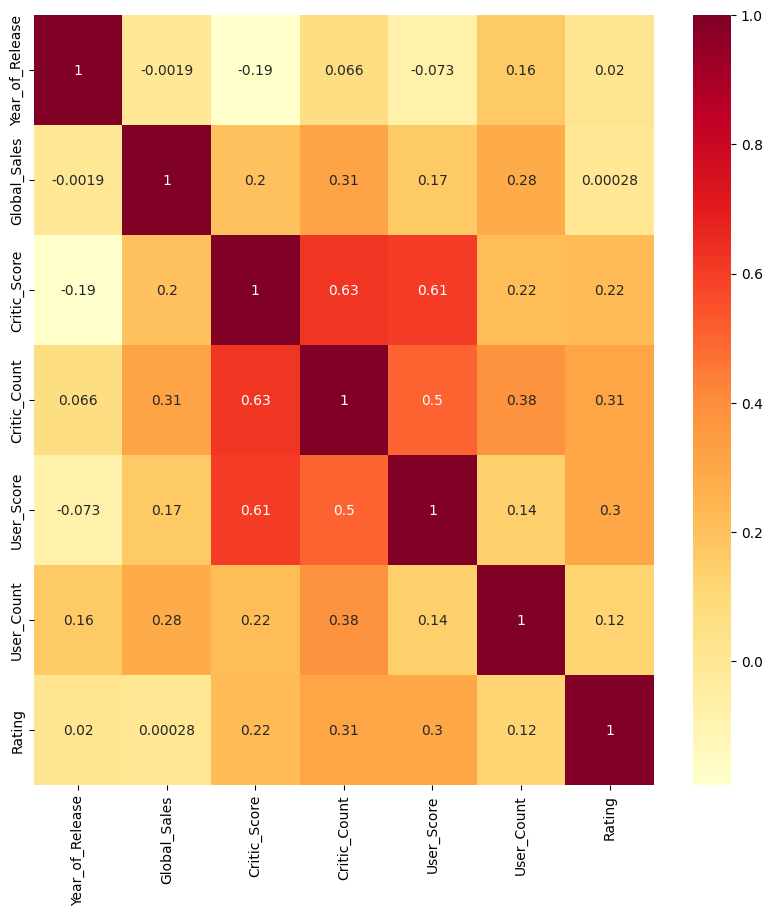

In [26]:
fig = plt.figure(figsize =(10,10))
sns.heatmap(df.iloc[:, :7].corr(), annot = True, cmap = 'YlOrRd')

По матрице корреляции можно увидеть, что итоговые продажи немного больше коррелируют с колическом критиков и пользователей, а с остальными признаками имеют примерно одинаковую корреляцию. Значит, все данные важны для итоговой модели, и никакие признаки удалять не стоит

# 1. Выбрать и обосновать метрику для измерения качества.

После анализа данных датасета, можно выбрать MAE (средняя абсолютная ошибка) как метрику для измерения качества. В будущем мы будем обучать модель регрессии, и MAE показывает среднее абсолютное отклонение предсказанных значений от реальных, предположим, что именно эта метрика будет подходить для нашей задачи.

Будем использовать MAE, так как нам небходимо оценить качество модели в целом и иметь понимание общего уровня ошибки (т.е. знать, насколько часто модель ошибается и насколько эти ошибки в среднем велики). К тому же в рамках данного задания не были удалены выбросы. MAE более устойчива к выбросам, чем другие метрики, такие как MSE, поскольку она не возводит ошибки в квадрат.

## PCA(n_components=3)

In [27]:
num_cols.head()

,Year_of_Release,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
0,2006.0,82.53,76.0,51.0,8.0,322.0
2,2008.0,35.52,82.0,73.0,8.3,709.0
3,2009.0,32.77,80.0,73.0,8.0,192.0
6,2006.0,29.80,89.0,65.0,8.5,431.0
7,2006.0,28.92,58.0,41.0,6.6,129.0


In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'Global_Sales')
Y = df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.2, random_state = 0)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)
X_train[:5]

array([[-0.62234841, -1.8688264 , -1.06091057, ...,  0.        ,
        -0.02263394,  0.        ],
       [-0.62234841,  0.93095724,  0.40451014, ...,  0.        ,
        -0.02263394,  0.        ],
       [-0.38495652, -0.23561927, -0.52358964, ...,  0.        ,
        -0.02263394,  0.        ],
       [ 0.08982724,  0.63098043, -0.42589493, ...,  0.        ,
        -0.02263394,  0.        ],
       [ 0.80200289, -0.56892685,  0.64874693, ...,  0.        ,
        -0.02263394,  0.        ]])

In [30]:
X_train.shape

(1953, 2018)

In [31]:
def draw_3d(data):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for f in data:
        ax.scatter(f[0], f[1], f[2], c='b')
    plt.show()

In [32]:
model = PCA(n_components=3)
X_train = model.fit_transform(X_train) 
X_test = model.transform(X_test) 
explained_variance = model.explained_variance_ratio_ 
print(explained_variance)

[0.00428314 0.00320168 0.00266202]


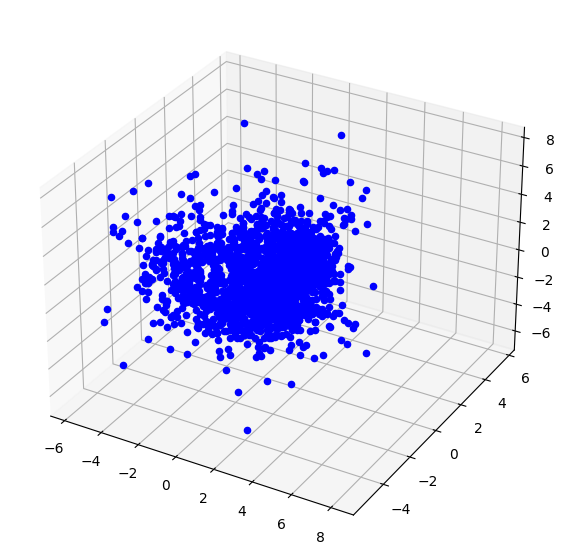

In [33]:
draw_3d(X_train)

Прежде чем перейти к обучению модели, проведем анализ лучших практик работы с этим датасетом:

1. https://www.kaggle.com/code/heraldoffate/visualizegamesales - в этой работе была проведена визуализация зависимости  всех данных друг от друга
2. https://www.kaggle.com/code/fatmazaher/video-game-sales-prediction - в этой работе был проведён анализ игровых платформ, жанров и стран продаж
3. https://www.kaggle.com/code/krishnabhatt4/video-game-sales-analysis - в этой работе была проведена визуализация многих данных, рассмотрены лучше признаки и их зависимости друг от друга

# 3. Построить и оценить качество бейзлайна

## Model

Обучим модель регресси на основе PCA модели

In [34]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression() 
regressor.fit(X_train, y_train)
print(regressor.intercept_) #коэффициент сдвига

y_pred = regressor.predict(X_test)
new_df = pd.DataFrame({'Actual': y_test, "Predicted": y_pred}) 
print(new_df.head())

0.6424782386072707
       Actual  Predicted
8219     0.17   0.448384
13423    0.05   0.579738
7970     0.19   0.086303
4434     0.44   0.660896
3134     0.64   0.664707


In [37]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

0.628189211266312

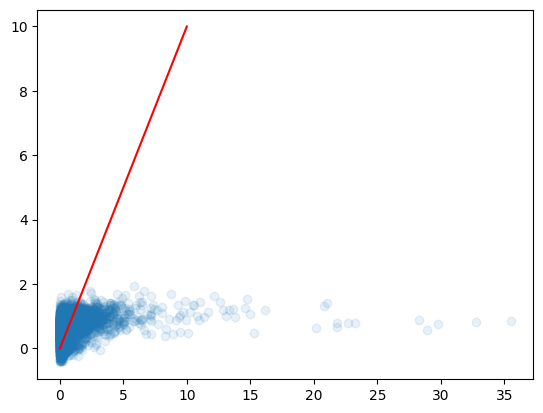

In [36]:
plt.scatter(y_test, y_pred, alpha=0.1)
(plt.plot([0, 10], [0, 10], 'r-'))

По этому графику можно сделать вывод, что большая часть данных была предсказана верно, хотя присутсвуют и отклонения (в т.ч. из-за того, что не были удалены выбросы)